# EfficientNetV2S

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/sub30

Mounted at /gdrive
/gdrive/MyDrive/sub30


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 2

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Set the global policy for mixed precision (16/32-bit float)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [ ]:
# Load the training data
data = np.load('filtered_data.npz')
X = data['images']
y = data['labels']

In [ ]:
# Convert labels to categorical format using one-hot encoding
from tensorflow.keras.utils import to_categorical
y = tfk.utils.to_categorical(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)

# Numero di classi nel dataset
num_classes = len(np.unique(y))  # Ad esempio, 8 classi

## 🛠️ Train and Save the Model

In [ ]:
# Input shape for the model
input_shape = X.shape[1:]

# Output shape for the model
output_shape = y.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
# Number of training epochs
epochs = 500

# Batch size for training
batch_size = 1024

# Learning rate: step size for updating the model's weights
learning_rate = 5e-4

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 500
Batch Size: 1024
Learning Rare: 0.0005


In [ ]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
net = tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling='max',
    include_preprocessing=True,
    name="efficientnetv2-s",
)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze all layers in EfficientNetB0 to use it solely as a feature extractor
net.trainable = False

# Apply data augmentation for training robustness
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(1),
    tfkl.RandomZoom(0.05),
    tfkl.RandomContrast(0.25),
], name='preprocessing')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl, models as tfk, losses, optimizers, initializers, regularizers
from tensorflow.keras.layers import Resizing

def build_model(
    input_shape,
    output_shape,
    learning_rate,
    seed,
    augmentation=None, # Add augmentation as an optional parameter
    l2_lambda=5e-2
):
    tf.random.set_seed(seed)

    # Define the input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    # Apply augmentation if provided (use a dictionary format for MixUp)
    if augmentation:
        x = augmentation(inputs)
    else:
        x = inputs

    # Weight initialization and regularization
    initializer = initializers.HeNormal(seed=seed)
    regularizer = regularizers.l2(l2_lambda)

    # Pass augmented inputs through the network feature extractor
    x = net(x)

    # Fully Connected Layers
    x = tfkl.Dense(64, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = tfkl.BatchNormalization(beta_regularizer=regularizer)(x)
    x = tfkl.Activation('relu')(x)

    # Output Layer
    outputs = tfkl.Dense(output_shape, kernel_initializer=initializer, kernel_regularizer=regularizer, activation='softmax', dtype='float32', name='output')(x)

    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Corrected loss and optimizer imports
    loss = losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Lion(learning_rate = 5e-4)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [ ]:
from sklearn.utils import class_weight
import numpy as np

if len(y_train.shape) > 1:
  y_train_int = np.argmax(y_train, axis=1)  # Converts one-hot to integer labels


# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)

# Convert the result into a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Build the model with specified input and output shapes
model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate, seed=seed, augmentation=augmentation)

# Display a summary of the model architecture
model.summary(expand_nested=False, show_trainable=True)

# Plot the model architecture with the correct import
# plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ cast_7 (Cast)                       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetv2-s (Functional)       │ (None, 1280)                 │    20,331,360 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 64)                   │        81,984 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_2               │ (None, 64)                   │           256 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_2 (Activation)           │ (None, 64)                   │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ cast_8 (Cast)                       │ (None, 64)                   │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ output (Dense)                      │ (None, 8)                    │           520 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,414,120 (77.87 MB)

 Trainable params: 82,632 (322.78 KB)

 Non-trainable params: 20,331,488 (77.56 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping directly
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the patience value for early stopping
patience = 30

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,          # Factor to reduce learning rate by (0.1 means divide by 10)
    patience=5,          # Number of epochs to wait before reducing
    min_lr=1e-5       # Minimum learning rate
)

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [reduce_lr,early_stopping]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight_dict,
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'NoPainNoTrain'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2334 - loss: 9.2061 - val_accuracy: 0.4147 - val_loss: 7.9147 - learning_rate: 5.0000e-04
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 694ms/step - accuracy: 0.5024 - loss: 7.3789 - val_accuracy: 0.6137 - val_loss: 6.6019 - learning_rate: 5.0000e-04
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 717ms/step - accuracy: 0.6487 - loss: 6.0583 - val_accuracy: 0.6839 - val_loss: 5.4795 - learning_rate: 5.0000e-04
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 704ms/step - accuracy: 0.7218 - loss: 5.0033 - val_accuracy: 0.7308 - val_loss: 4.5208 - learning_rate: 5.0000e-04
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 699ms/step - accuracy: 0.7559 - loss: 4.1390 - val_accuracy: 0.7416 - val_loss: 3.7806 - learning_rate: 5.0000e-04
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 631ms/step - accuracy: 0.7827 - loss: 3.4250 - val_accuracy: 0.7316 - val_loss: 3.2705 - learning_rate: 5.0000e-04
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 658ms/step - 

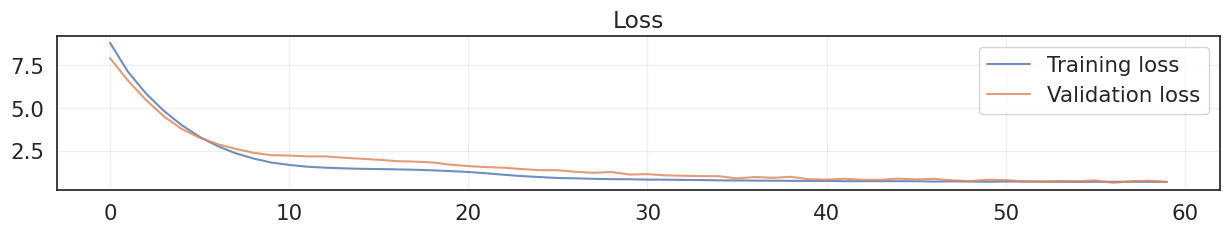

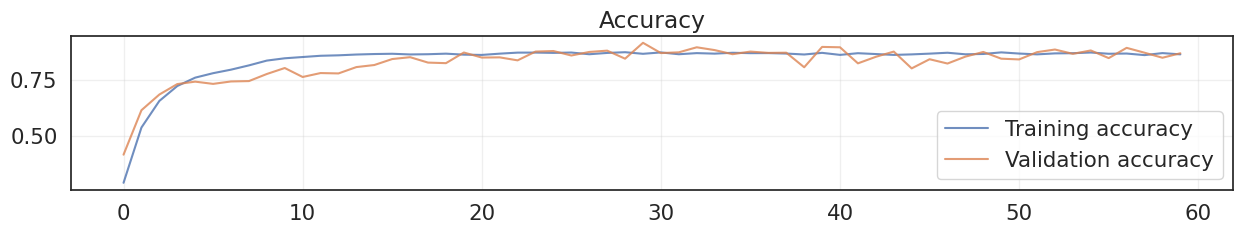

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
print(model_filename)

NoPainNoTrain91.56.keras


In [ ]:
# Re-load the model after transfer learning
ft_model = tf.keras.models.load_model('NoPainNoTrain91.56.keras')

# Display a summary of the model architecture
# ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Set all EfficientNetB0 layers as non-trainable
for layer in ft_model.get_layer('efficientnetv2-s').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 stem_conv Conv2D True
5 block1a_project_conv Conv2D True
9 block1b_project_conv Conv2D True
14 block2a_expand_conv Conv2D True
17 block2a_project_conv Conv2D True
19 block2b_expand_conv Conv2D True
22 block2b_project_conv Conv2D True
26 block2c_expand_conv Conv2D True
29 block2c_project_conv Conv2D True
33 block2d_expand_conv Conv2D True
36 block2d_project_conv Conv2D True
40 block3a_expand_conv Conv2D True
43 block3a_project_conv Conv2D True
45 block3b_expand_conv Conv2D True
48 block3b_project_conv Conv2D True
52 block3c_expand_conv Conv2D True
55 block3c_project_conv Conv2D True
59 block3d_expand_conv Conv2D True
62 block3d_project_conv Conv2D True
66 block4a_expand_conv Conv2D True
69 block4a_dwconv2 DepthwiseConv2D True
74 block4a_se_reduce Conv2D True
75 block4a_se_expand Conv2D True
77 block4a_project_conv Conv2D True
79 block4b_expand_conv Conv2D True
82 block4b_dwconv2 DepthwiseConv2D True
87 block4b_se_reduce Conv2D True
88 block4b_se_expand Conv2D True
90 block4b_project_c

In [ ]:
# Set the number of layers to freeze

# Calcola i parametri totali
trainable_params = sum(
    tf.reduce_sum([tf.size(var) for var in layer.trainable_weights]).numpy()
    for layer in ft_model.get_layer('efficientnetv2-s').layers
)
target_params = 0.9 * trainable_params  # Il 10% dei parametri totali

# Trova N
cumulative_params = 0
N = 0
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
    cumulative_params += sum(tf.size(var).numpy() for var in layer.trainable_weights)
    if cumulative_params >= target_params:
        N = i
        break

print(N)

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
 #ft_model.summary(expand_nested=False, show_trainable=True)


# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

480
0 input_layer_4 False
1 rescaling_2 False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block2d_expand_conv False
34 block2d_expand_bn False
35 block2d_expand_activation False
36 block2d_project_conv F

In [ ]:
# Compile the model
loss = losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Lion(learning_rate = 1e-4)
metrics = ['accuracy']
ft_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Fine-tune the model
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping directly
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Factor to reduce learning rate by (0.1 means divide by 10)
    patience=5,          # Number of epochs to wait before reducing
    min_lr=5e-6       # Minimum learning rate
)

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [reduce_lr,early_stopping]

ft_history = ft_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'NoPainNoTrainFT'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8900 - loss: 0.7949 - val_accuracy: 0.9206 - val_loss: 1.0223 - learning_rate: 1.0000e-04
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 755ms/step - accuracy: 0.9071 - loss: 0.7255 - val_accuracy: 0.9264 - val_loss: 0.9418 - learning_rate: 1.0000e-04
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 736ms/step - accuracy: 0.9116 - loss: 0.6900 - val_accuracy: 0.9197 - val_loss: 0.9045 - learning_rate: 1.0000e-04
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 664ms/step - accuracy: 0.9220 - loss: 0.6506 - val_accuracy: 0.9055 - val_loss: 0.8880 - learning_rate: 1.0000e-04
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 660ms/step - accuracy: 0.9241 - loss: 0.6320 - val_accuracy: 0.9214 - val_loss: 0.8678 - learning_rate: 1.0000e-04
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 680ms/step - accuracy: 0.9309 - loss: 0.5954 - val_accuracy: 0.9465 - val_loss: 0.8580 - learning_rate: 1.0000e-04
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 721ms/step - a

In [ ]:
print(model_filename)

NoPainNoTrainFT97.58.keras


## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('NoPainNoTrainFT95.09.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py NoPainNoTrainFT95.09.keras

from google.colab import files
files.download(filename)